# LSTM Model Test

Long short-term memory is a recurrent neural network used to model sequential data. For this specific use, we wanted a model that would be able to analyze patterns and trends for a given stock data.

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


from tensorflow.keras import models
from tensorflow.keras.layers import LSTM,Dense

In [99]:
df_prices = pd.read_csv('./data/prices-split-adjusted.csv')
df_prices.fillna(float(0))
df_prices['date'] = pd.to_datetime(df_prices['date'])

df_prices = df_prices[df_prices['symbol']=='ABC']
df_prices = df_prices.drop(columns=['symbol'])
df_dates = df_prices['date'].copy()
df_prices = df_prices.set_index('date')

df = df_prices['close'].to_frame()

df.head()

,close
date,
2010-01-04,26.629999
2010-01-05,26.440001
2010-01-06,26.190001
2010-01-07,25.770000
2010-01-08,26.049999


In [100]:
def prep_data(df, scaler, split):
    df = scaler.fit_transform(np.array(df).reshape(-1,1))
    size = int(len(df)*split)

    train_data = df[0:size,:]
    test_data = df[size:,:]
    
    return train_data, test_data

def fix_data(data, scaler):
    return scaler.inverse_transform(np.array(data).reshape(-1,1))

def build_data(data, step):
    x, y = [], []
    
    for i in range(len(data)-step-1):
        x.append(data[i:(i+step),0])
        y.append(data[i+step,0])
        
    return np.array(x), np.array(y)


def build_model(optimizer, step):
    model = models.Sequential()

    model.add(LSTM(64,return_sequences=True,input_shape=(step,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(32,return_sequences=True))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    model.summary()
    
    return model

In [101]:
split = 0.7
step = 60

standard = StandardScaler()
min_max = sklearn.preprocessing.MinMaxScaler()

scaler = standard

train_data, test_data = prep_data(df, scaler, split)

X_train, y_train = build_data(train_data, step)
X_test, y_test = build_data(test_data, step)

print("X Training Shape: "+str(X_train.shape))
print("X Test Shape: "+str(X_test.shape))
print("Y Training Shape: "+str(y_train.shape))
print("Y Test Shape: "+str(y_test.shape))

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X Training Shape: (1172, 60)
X Test Shape: (468, 60)
Y Training Shape: (1172,)
Y Test Shape: (468,)


In [102]:
model = build_model('adam',step)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 60, 64)            16896     
_________________________________________________________________
lstm_17 (LSTM)               (None, 60, 50)            23000     
_________________________________________________________________
lstm_18 (LSTM)               (None, 60, 32)            10624     
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 67,171
Trainable params: 67,171
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.fit(X_train,y_train,epochs=40,batch_size=32)

y_hat = model.predict(X_test)

error = np.sqrt(mean_squared_error(y_test,y_hat))

y_test = fix_data(y_test, scaler)
y_hat = fix_data(y_hat, scaler)

error

Epoch 1/40
37/37 [==============================] - 3s 69ms/step - loss: 0.0728
Epoch 2/40
37/37 [==============================] - 2s 65ms/step - loss: 0.0084
Epoch 3/40
37/37 [==============================] - 3s 69ms/step - loss: 0.0060
Epoch 4/40
37/37 [==============================] - 3s 70ms/step - loss: 0.0057
Epoch 5/40
37/37 [==============================] - 3s 75ms/step - loss: 0.0053
Epoch 6/40
37/37 [==============================] - 3s 72ms/step - loss: 0.0045
Epoch 7/40
37/37 [==============================] - 2s 67ms/step - loss: 0.0049
Epoch 8/40
37/37 [==============================] - 3s 74ms/step - loss: 0.0040
Epoch 9/40
37/37 [==============================] - 3s 74ms/step - loss: 0.0042
Epoch 10/40
37/37 [==============================] - 3s 70ms/step - loss: 0.0043
Epoch 11/40
37/37 [==============================] - 3s 73ms/step - loss: 0.0043
Epoch 12/40
37/37 [==============================] - 3s 72ms/step - loss: 0.0034
Epoch 13/40
37/37 [==================

0.11429679004578643

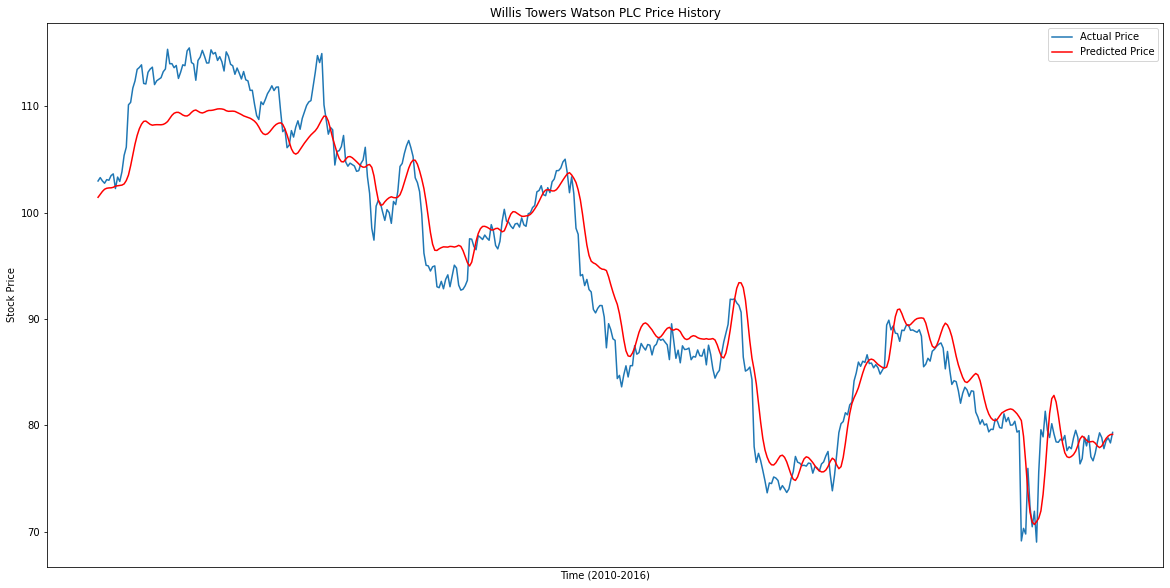

In [104]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax.plot(y_test,label='Actual Price')
ax.plot(y_hat, c='r', label='Predicted Price')
ax.set_title('Willis Towers Watson PLC Price History')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Time (2010-2016)')
ax.tick_params(axis='x',
               which='both',
               bottom=False,
               top=False,
               labelbottom=False)
ax.legend()

In [128]:
data = np.array(df.copy()).reshape((-1))

def predict(data, num_prediction, look_back, model):
    prediction_list = data[-look_back:]
    data = [prediction_list, prediction_list]
    x = build_data(data, 15)
#     print(prediction_list)
    
#     for _ in range(num_prediction)
#     x = prediction_list[-look_back:]
#     x = np.asarray(x).astype('float64')
    print(x)
    x = x.reshape(x.shape[0],x.shape[1],1)
    out = model.predict(x)
    print(out)
    prediction_list = np.append(prediction_list, out)
#     prediction_list = prediction_list[look_back-1:]
    
        
    return prediction_list
    
def predict_dates(num_prediction, dates):
    last_date = dates.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates


# look_back = 15
# num_prediction = 30
forecast = predict(data, num_prediction, look_back, model)
# forecast_dates = predict_dates(num_prediction, df_dates)

# forecast_data = {'forecast': forecast, 'date': forecast_dates}
# df_forecast = pd.DataFrame(data)
# df_forecast = df_forecast.set_index('date')

# df_test = pd.DataFrame(data=y_test)

# print(df_forecast.head())

# y_test
X_train.shape

(array([], dtype=float64), array([], dtype=float64))


AttributeError: 'tuple' object has no attribute 'reshape'

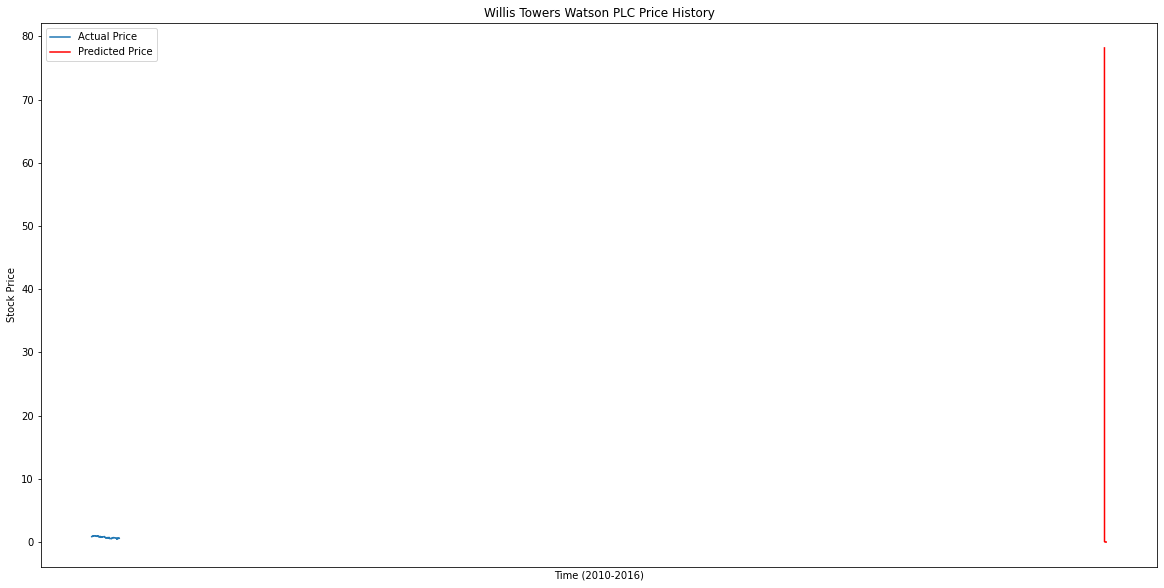

In [51]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax.plot(y_test,label='Actual Price')
ax.plot(df_forecast['forecast'], c='r', label='Predicted Price')
ax.set_title('Willis Towers Watson PLC Price History')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Time (2010-2016)')
ax.tick_params(axis='x',
               which='both',
               bottom=False,
               top=False,
               labelbottom=False)
ax.legend()